#                                           K-Means Clustering

## Problem Statement

A key challenge for Mobile App businesses is to analyze the trend in the market to increase their sales/usage. 

We have access to the user's demographic characteristics, geolocation, and mobile device properties. This grouping can be done by applying different criteria like user’s data, their age group, phone brand compatibility and so on. 

The machine learning clustering algorithms can provide an analytical method to cluster user segments with similar interests/habits.This will help App/mobile providers better understand and interact with their subscribers. 


## Data Definition


**events.csv** - Event data has an event id, location detail (lat/long), and timestamp, when the user is using an app on his device
 
**gender_age.csv** - details of users age & gender
 
**phone_device.csv** - Device ids, brand, and models name. here the brands names are in Chinese, you can convert it in english using google for better understanding but we will not do it here. 

### Import Important library and functions

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import numpy as np
# 'Pandas' is used for data manipulation and analysis
import pandas as pd
# 'Seaborn' is based on matplotlib; used for plotting statistical graphics
import seaborn as sns
from operator import add
from scipy import sparse, io
# 'Matplotlib' is a data visualization library for 2D and 3D plots, built on numpy
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# Jupyter specific plotting display function
%matplotlib notebook
%matplotlib inline
# suppress display of warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Preprocessing the data

*First thing first- Let's start importing all input data & start exploring all data points

In [ ]:
events= pd.read_csv('/content/gdrive/My Drive/EXL/events.csv',encoding='utf-8')

In [ ]:
Age= pd.read_csv('/content/gdrive/My Drive/EXL/gender_age.csv',encoding='utf-8')

In [ ]:
phone_brand= pd.read_csv('/content/gdrive/My Drive/EXL/phone_device.csv',encoding='utf-8')

In [ ]:
events.head(3)

,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70


In [ ]:
Age.head(3)

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38


In [ ]:
phone_brand.head()

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


*Here in Phone Brand data, phone brand & model name is in chinease/different language. We can google it to convert in engish or use any translation API to learn performing language translation. If you are doing manually through google, i will suggest first get the distrubution of each brand and only convert for top 10/12 contributiong for say 90/95%. For simplicity, we will not do anything here for our use case. We will use it as given. Few important conversion is listed below-
三星 samsung

天语 Ktouch

海信 hisense

联想 lenovo

爱派尔 ipair

一加 oneplus

诺基亚 nokia

华硕 asus

夏新 panosonic

锤子 hammer

In [ ]:
#check duplicates in device id & clean it
phone_devices_unique=np.unique(phone_brand['device_id'].values)
print("Number of Unique Phone Device: ",len(phone_devices_unique))
print("Total Number of Devices in Phone Data: ",phone_brand.shape[0])
print("Number of Duplicate Devices: ",phone_brand.shape[0]-len(phone_devices_unique))

Number of Unique Phone Device:  186716
Total Number of Devices in Phone Data:  187245
Number of Duplicate Devices:  529


In [ ]:
#remove duplicates
phone_brand = phone_brand.drop_duplicates('device_id', keep='first')
phone_brand.shape[0]

186716

In [ ]:
#Merge all data together. We can do it all together but better do one by one and learn new dimensions of data
labelled_data = (events.merge(phone_brand, how='left', on='device_id')
                            .merge(Age, how='left', on='device_id')
                            )

In [ ]:
# Check new data frame look
labelled_data.head(2)

,event_id,device_id,timestamp,longitude,latitude,phone_brand,device_model,gender,age,group
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,小米,红米note,M,46.0,M39+
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,三星,Galaxy Grand Prime,NaN,NaN,NaN


In [ ]:
# let's analyze timestamp data
event_time=labelled_data['timestamp'].values
print("Event Start: ",np.min(event_time))
print("Event End: ",np.max(event_time))

Event Start:  2016-04-30 23:52:24
Event End:  2016-05-08 00:00:08


*The Events Data provided is for a period of 7 Days Starting from 30th April 2016 mid-night to starting of 8th May 2016

In [ ]:
labelled_data.shape

(3252950, 10)

In [ ]:
df = labelled_data.dropna()
df.shape

(1215595, 10)

### Exploratory Data Analysis (EDA)

*Data preparation is the process of cleaning and transforming raw data before building the models
You should always explore all the data points and try building your initial hypothesis to see if that factor/variable can help you in solving your main problem statement/your goal

Here we analyze the data with the following steps:
1. Check dimensions of the dataframe in terms of rows and columns and study  few of the variables
2. Check the data types
3. Check the frequency and distribution of the relevant features
4. Convert string features (phone_brand, device_model and gender ) into categories and make them numerical
5. Study summary statistics and mention your findings
6. Check for missing values and impute/drop missing values if any
7. Drop irrelevant columns like 'timestamp','event_id','device_id' 
8. Standardize the data to bring relevant features into a scale

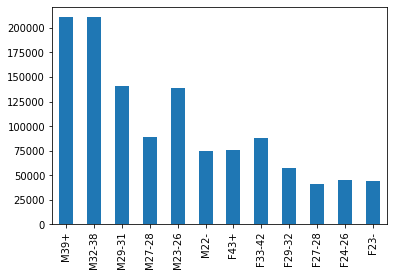

In [ ]:
df.group.value_counts().sort_index(ascending=False).plot(kind='bar')

* Male gender age group is more than Female gender age group

* Lets explore proportion of male & female in data set

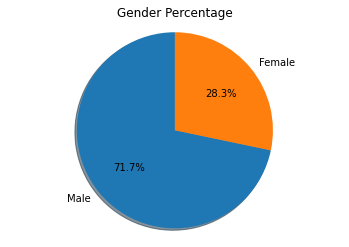

In [ ]:
gender_dict = df['gender'].value_counts()
gender_labels=['Male','Female']
male_percentage=(gender_dict['M']*100)//df.shape[0]
female_percentage=(gender_dict['F']*100)//df.shape[0]
sizes=[male_percentage,female_percentage]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=gender_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Gender Percentage')
plt.show()

*Gender representATION Is not Balanced. 2/3rd are Males

* Lets check there age distribution

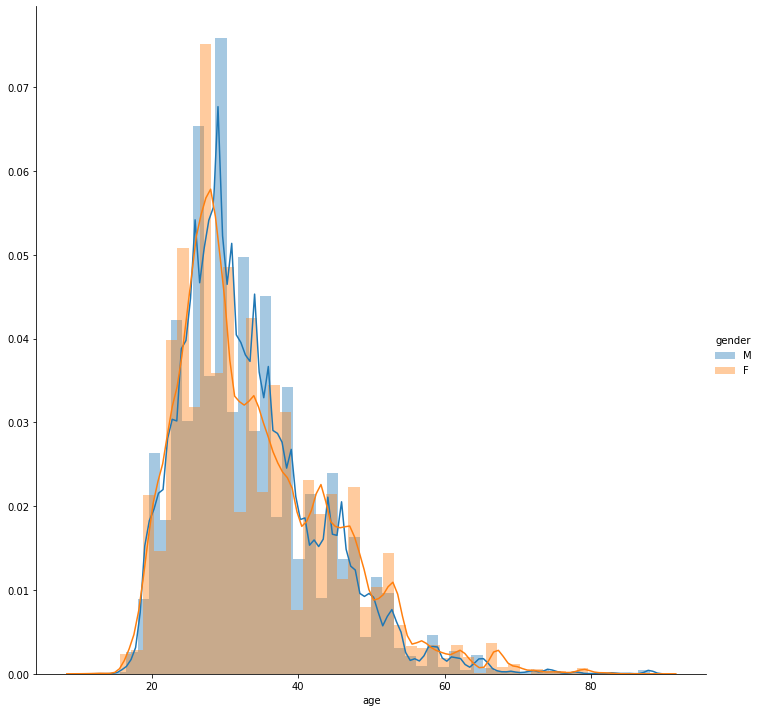

In [ ]:
sns.FacetGrid(df, hue="gender", size=10).map(sns.distplot, "age").add_legend();
plt.show()

* Mostely overlap in the Number of Male and Female in age group below 46/47 but number of female are slightly more than Male in the age group above 46

In [ ]:
#still we have more than 6 lakhs data point to work. Good to go....
df.describe()

,event_id,device_id,longitude,latitude,age
count,1.215595e+06,1.215595e+06,1.215595e+06,1.215595e+06,1.215595e+06
mean,1.626676e+06,-3.115914e+16,7.839399e+01,2.182756e+01,3.350031e+01
std,9.396637e+05,5.322373e+18,5.381238e+01,1.564825e+01,9.745486e+00
min,1.000000e+00,-9.222957e+18,-1.800000e+02,-3.380000e+01,1.100000e+01
25%,8.123210e+05,-4.672948e+18,0.000000e+00,0.000000e+00,2.700000e+01
50%,1.627312e+06,-1.188460e+17,1.127500e+02,2.857000e+01,3.100000e+01
75%,2.440382e+06,4.631837e+18,1.171700e+02,3.401000e+01,3.900000e+01
max,3.252948e+06,9.220915e+18,1.511800e+02,5.364000e+01,8.900000e+01


* In our dataset, we have both numerical and categorical variables. We check for summary statistics of all the variables

1. For numerical variables, use .describe()
2. For categorical variables, use .describe(include=object) 

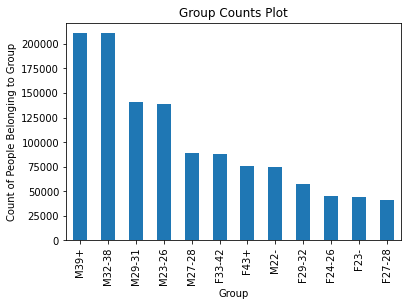

In [ ]:
#see distribution of gender & age(Group) column again
plt.title('Group Counts Plot')
plt.xlabel('Group')
plt.ylabel('Count of People Belonging to Group')
df['group'].value_counts().plot.bar()
plt.show()

*seems ratio is maintained after random sampling. Good to go...

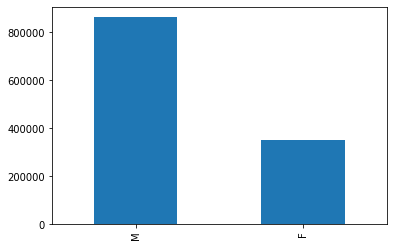

In [ ]:
df.gender.value_counts().plot(kind='bar')
#Expected as per original proportion. Good to go...

In [ ]:
df.head(2)

,event_id,device_id,timestamp,longitude,latitude,phone_brand,device_model,gender,age,group
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,小米,红米note,M,46.0,M39+
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,魅族,MX4 Pro,M,47.0,M39+


In [ ]:
#lets convert the category data as numeric encoder
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
#dff = df.copy()
df['phone_brand_Cat'] = labelencoder.fit_transform(df['phone_brand'])
df['device_model_Cat'] = labelencoder.fit_transform(df['device_model'])

In [ ]:

df = pd.get_dummies(df, columns=["gender"], prefix=["Type_is"] )

df.head(2)

,event_id,device_id,timestamp,longitude,latitude,phone_brand,device_model,age,group,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24,小米,红米note,46.0,M39+,34,864,0,1
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70,魅族,MX4 Pro,47.0,M39+,87,419,0,1


In [ ]:
#Let's drop original identity data as that will not help in our analysis
dff= df.drop(['group','phone_brand','device_model','timestamp','event_id','device_id'],axis=1)

In [ ]:
dff.head(3)

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M
0,121.38,31.24,46.0,34,864,0,1
2,106.60,29.70,47.0,87,419,0,1
3,104.27,23.28,30.0,8,744,0,1


*Feature scaling is a technique to standardize the independent features present in the data in a fixed range. If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.

The two most discuss scaling methods are normalization and standardization.

- Normalization: It should be used if there are any predefined assumptions of the model. In this approach, the data is scaled to a fixed range - usually 0 to 1
- Standardization: It is used when we are dealing with multiple variables together. In this technique, the features will be rescaled so that they’ll have the properties of a standard normal distribution with (mean = 0 and sd = 1)

In [ ]:
#lets compare apple to apple; scale the data
# initiate and fit StandardScaler function
from sklearn.preprocessing import StandardScaler
scale = StandardScaler().fit(dff)       

# scale the 'features' data
features = scale.transform(dff)

In [ ]:
# create a dataframe of the scaled features 
features_scaled = pd.DataFrame( features, columns= dff.columns[0:7])

# head() to display top five rows
features_scaled.head()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M
0,0.798813,0.601501,1.282614,0.228520,0.930037,-0.637531,0.637531
1,0.524155,0.503088,1.385226,2.389503,-0.722231,-0.637531,0.637531
2,0.480856,0.092818,-0.359172,-0.831585,0.484482,-0.637531,0.637531
3,0.696606,0.436626,-0.564396,2.104091,0.774093,1.568552,-1.568552
4,-1.456803,-1.394889,-1.487900,-0.301532,-0.707379,-0.637531,0.637531


### Clustering

*Centroid-based clustering algorithms cluster the data into non-hierarchical clusters. Such algorithms are efficient but sensitive to initial conditions and outliers. K-means is the most widely-used centroid-based clustering algorithm

In [ ]:
features_scaled.shape

(1220474, 7)

### Taking a sample of data for building the clustering model to avoid compuation issues

In [ ]:
sample = features_scaled.sample(20000)

In [ ]:
from sklearn.cluster import KMeans
# Using the elbow method to find the optimal number of clusters
wcss =[]
for i in range (1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter =300, n_init = 10, random_state = 0)
    kmeans.fit(sample)
    wcss.append(kmeans.inertia_)

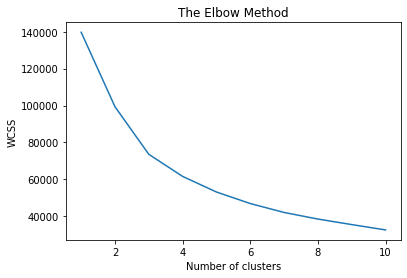

In [ ]:
# Plot the graph to visualize the optimal number of cluster through the Elbow Method
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

*We build our models using the silhouette score method. The silhouette is a method of interpretation and validation of consistency within clusters of data.
We do not know how many clusters give the most useful results. So, we create the clusters varying K, from 3 to 6 and then decide the optimum number of clusters (K) with the help of the silhouette score

In [ ]:
#using silhouette score: Higher the value, better the cluster. Earlier run suggested 3
from sklearn.metrics import silhouette_score
# create a list for different values of K
n_clusters = [3, 4, 5, 6]

# use 'for' loop to build the clusters
# 'random_state' creates the sample in the same order 
# fit and predict on the scaled data
# 'silhouette_score' function computes the silhouette score for each K
for K in n_clusters:
    cluster = KMeans (n_clusters= K, random_state= 10)
    predict = cluster.fit_predict(sample)
    
    score = silhouette_score(sample, predict, random_state= 10)
    print ("For n_clusters = {}, silhouette score is {})".format(K, score))

For n_clusters = 3, silhouette score is 0.3645355941025411)
For n_clusters = 4, silhouette score is 0.4077746292224422)
For n_clusters = 5, silhouette score is 0.3449513625052105)
For n_clusters = 6, silhouette score is 0.3646232682257248)


* The optimum value for K is associated with the high value of the 'silhouette score'. From the above output it can be seen that, for K = 4, the silhouette score is highest. Thus, we will try to build the clusters with K = 4 

In [ ]:
#run raw cluster algo
kmeans = KMeans(n_clusters=4, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
kmeans = kmeans.fit(features_scaled)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 0.67654497  0.62837992 -0.02395921 -0.03623467  0.0683094  -0.63655212
   0.63655212]
 [-1.45954576 -1.38856986 -0.01833148  0.1897685  -0.08088257 -0.63655212
   0.63655212]
 [ 0.68271398  0.69390875  0.06008904 -0.12643584  0.01717655  1.57096328
  -1.57096328]
 [-1.45521377 -1.38998121  0.04588938  0.00824522 -0.19161217  1.57096328
  -1.57096328]]


In [ ]:
# add a column 'cluster' in the data giving cluster number corresponding to each observation
dff['cluster'] = kmeans.labels_

# head() to display top five rows
dff.head()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
0,121.38,31.24,46.0,34,864,0,1,0
2,106.60,29.70,47.0,87,419,0,1,0
3,104.27,23.28,30.0,8,744,0,1,0
4,115.88,28.66,28.0,80,822,1,0,2
5,0.00,0.00,19.0,21,423,0,1,1


In [ ]:
# 'return_counts = True' gives the number observation in each cluster
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([608090, 260452, 224927, 127005]))

### Cluster Profiling

*we analyze all the cluster formed. Few steps are:

1. Add a cluster label column created using the clustering algorithm in your original dataframe
2. Compute the statistical summary for observations in each cluster(Check mean, sd, freq, modes, min, max, range..all basic central tendency numbers for each cluster(hint: dataframe[dataframe.cluster==0].describe() for 0th cluster, similarly do for other clusters) )
3. Perform bivariate analysis between cluster labels and other features 


In [ ]:
dff['Type_is_F'].value_counts()

0    868542
1    351932
Name: Type_is_F, dtype: int64

In [ ]:
# get summary for observations in the cluster
dff[dff.cluster==0].describe()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
count,608090.000000,608090.000000,608090.000000,608090.000000,608090.000000,608090.0,608090.0,608090.0
mean,114.817385,31.666090,33.253166,27.491501,631.562469,0.0,1.0,0.0
std,6.028856,5.979823,9.373655,23.128814,266.635804,0.0,0.0,0.0
min,6.750000,12.960000,14.000000,1.000000,1.000000,0.0,1.0,0.0
25%,112.440000,27.820000,27.000000,10.000000,407.000000,0.0,1.0,0.0
50%,114.950000,31.190000,31.000000,21.000000,730.000000,0.0,1.0,0.0
75%,119.360000,36.080000,38.000000,34.000000,880.000000,0.0,1.0,0.0
max,139.430000,52.320000,88.000000,87.000000,922.000000,0.0,1.0,0.0


In [ ]:
# I will rename the cluster name generic, but you all should give it a intutive names like frequent users, entertainment centrics etc
G_1=dff[dff.cluster==0]
G_1.Type_is_F.sum()

0

In [ ]:
G_1.Type_is_M.sum()

608090

In [ ]:
# get summary for observations in the cluster
dff[dff.cluster==1].describe()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
count,260452.000000,260452.000000,260452.000000,260452.000000,260452.000000,260452.0,260452.0,260452.0
mean,-0.131488,0.108169,33.307972,33.036391,591.379006,0.0,1.0,1.0
std,5.539063,1.297867,9.545738,28.242770,275.511914,0.0,0.0,0.0
min,-180.000000,-33.800000,12.000000,0.000000,1.000000,0.0,1.0,1.0
25%,0.000000,0.000000,26.000000,10.000000,317.000000,0.0,1.0,1.0
50%,0.000000,0.000000,31.000000,21.000000,586.000000,0.0,1.0,1.0
75%,0.000000,0.000000,39.000000,34.000000,875.000000,0.0,1.0,1.0
max,151.180000,45.530000,88.000000,88.000000,925.000000,0.0,1.0,1.0


In [ ]:
# get summary for observations in the cluster
dff[dff.cluster==2].describe()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
count,224927.000000,224927.000000,224927.000000,224927.000000,224927.000000,224927.0,224927.0,224927.0
mean,115.149356,32.691378,34.071672,25.278455,617.790314,1.0,0.0,2.0
std,6.268337,6.067649,10.427528,21.558743,261.868111,0.0,0.0,0.0
min,-1.780000,7.870000,16.000000,1.000000,0.000000,1.0,0.0,2.0
25%,112.740000,29.045000,26.000000,10.000000,407.000000,1.0,0.0,2.0
50%,115.950000,31.870000,31.000000,21.000000,685.000000,1.0,0.0,2.0
75%,119.150000,37.860000,41.000000,34.000000,875.000000,1.0,0.0,2.0
max,139.560000,53.640000,86.000000,87.000000,922.000000,1.0,0.0,2.0


In [ ]:
# get summary for observations in the cluster
dff[dff.cluster==3].describe()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
count,127005.000000,127005.000000,127005.000000,127005.000000,127005.000000,127005.0,127005.0,127005.0
mean,0.101628,0.086087,33.933388,28.582796,561.555025,1.0,0.0,3.0
std,1.310899,0.324390,10.493535,26.439060,272.629925,0.0,0.0,0.0
min,-122.320000,-0.490000,11.000000,1.000000,1.000000,1.0,0.0,3.0
25%,0.000000,0.000000,26.000000,10.000000,311.000000,1.0,0.0,3.0
50%,0.000000,0.000000,31.000000,21.000000,517.000000,1.0,0.0,3.0
75%,0.000000,0.000000,40.000000,34.000000,864.000000,1.0,0.0,3.0
max,103.840000,47.640000,89.000000,87.000000,923.000000,1.0,0.0,3.0


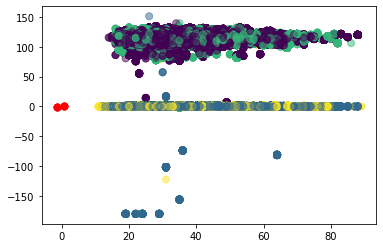

In [ ]:
plt.scatter(dff['age'], dff['longitude'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

# Dimensionality reduction using PCA

In [ ]:
#lets do dimension reduction using PCA
from sklearn.decomposition import PCA

In [ ]:
# i am restricting to 2 component but you all should do proper pca to find out optimum number of component
pca_reducer = PCA(n_components=2)
reduced_data = pca_reducer.fit_transform(features_scaled)

In [ ]:
reduced_data.shape

(1220474, 2)

### Applying k-means on PCA transformed data

In [ ]:
# Let's try again with K means
km = KMeans(n_clusters=4,random_state = 108)
cluster = km.fit(reduced_data)

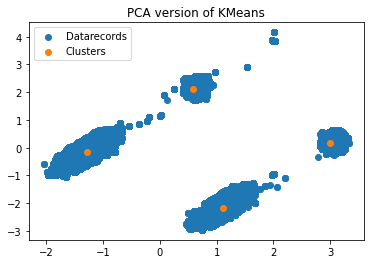

In [ ]:
# Good improvement..good to go
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], label='Datarecords')
plt.scatter(cluster.cluster_centers_[:, 0], cluster.cluster_centers_[:, 1], label='Clusters')
plt.title("PCA version of KMeans")
plt.legend()
plt.show()

In [ ]:
#Add labels back to original data
dff['cluster'] = cluster.labels_

# head() to display top five rows
dff.head()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
0,121.38,31.24,46.0,34,864,0,1,2
2,106.60,29.70,47.0,87,419,0,1,2
3,104.27,23.28,30.0,8,744,0,1,2
4,115.88,28.66,28.0,80,822,1,0,1
5,0.00,0.00,19.0,21,423,0,1,0


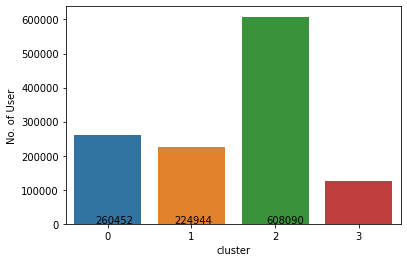

In [ ]:
import seaborn as sns
sns.countplot(data= dff, x = 'cluster')

# give a name to the y-axis
plt.ylabel('No. of User')         

# add values in the graph
plt.text(x = -0.15, y =2000, s = np.unique(cluster.labels_, return_counts=True)[1][0])
plt.text(x = 0.8, y =2000, s = np.unique(cluster.labels_, return_counts=True)[1][1])
plt.text(x = 1.9, y =2000, s = np.unique(cluster.labels_, return_counts=True)[1][2])

plt.show()

In [ ]:
G_1=dff[dff.cluster==0]
G_1.head(3)

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
5,0.0,0.0,19.0,21,423,0,1,0
34,0.0,0.0,28.0,21,878,0,1,0
38,0.0,0.0,26.0,21,891,0,1,0


In [ ]:
print("In cluster zero we have: {} customers".format(G_1.shape[0]))
print("Average age for customers in cluster zero: {}".format(np.array(G_1['age']).mean()))
print("Deviation of the mean for age for customers in cluster zero: {}".format(np.array(G_1['age']).std()))
print("We have {} male".format((G_1['Type_is_M'] == 1).sum()))
print("We have {} female".format((G_1['Type_is_F'] == 1).sum()))

In cluster zero we have: 260452 customers
Average age for customers in cluster zero: 33.30797229431911
Deviation of the mean for age for customers in cluster zero: 9.545719206693539
We have 260452 male
We have 0 female


In [ ]:
G_2=dff[dff.cluster==1]
print("In cluster one we have: {} customers".format(G_2.shape[0]))
print("Average age for customers in cluster one: {}".format(np.array(G_2['age']).mean()))
print("Deviation of the mean for age for customers in cluster one: {}".format(np.array(G_2['age']).std()))
print("We have {} male".format((G_2['Type_is_M'] == 1).sum()))
print("We have {} female".format((G_2['Type_is_F'] == 1).sum()))

In cluster one we have: 224944 customers
Average age for customers in cluster one: 34.071288854114805
Deviation of the mean for age for customers in cluster one: 10.427203630710192
We have 0 male
We have 224944 female


In [ ]:
G_3=dff[dff.cluster==2]
print("In cluster two we have: {} customers".format(G_3.shape[0]))
print("Average age for customers in cluster two: {}".format(np.array(G_3['age']).mean()))
print("Deviation of the mean for age for customers in cluster two: {}".format(np.array(G_3['age']).std()))
print("We have {} male".format((G_3['Type_is_M'] == 1).sum()))
print("We have {} female".format((G_3['Type_is_F'] == 1).sum()))

In cluster two we have: 608090 customers
Average age for customers in cluster two: 33.25316647206828
Deviation of the mean for age for customers in cluster two: 9.37364724050091
We have 608090 male
We have 0 female


In [ ]:
G_4=dff[dff.cluster==3]
print("In cluster two we have: {} customers".format(G_4.shape[0]))
print("Average age for customers in cluster two: {}".format(np.array(G_4['age']).mean()))
print("Deviation of the mean for age for customers in cluster two: {}".format(np.array(G_4['age']).std()))
print("We have {} male".format((G_4['Type_is_M'] == 1).sum()))
print("We have {} female".format((G_4['Type_is_F'] == 1).sum()))

In cluster two we have: 126988 customers
Average age for customers in cluster two: 33.93404888650896
Deviation of the mean for age for customers in cluster two: 10.494040362702654
We have 0 male
We have 126988 female


In [ ]:
cat = df[['phone_brand','phone_brand_Cat']]
cat.sample(10)

,phone_brand,phone_brand_Cat
1214628,小米,34
1165,华为,21
2929994,魅族,87
1972472,三星,10
138307,小米,34
3244691,三星,10
565235,OPPO,4
2696160,酷派,80
2497368,小米,34
1156800,OPPO,4


In [ ]:
G_1['phone_brand_Cat'].value_counts().head(10)

21    69222
10    38893
34    36923
87    28708
4     17976
80    14268
8     11367
67     8998
14     4994
82     3376
Name: phone_brand_Cat, dtype: int64

In [ ]:
G_2['phone_brand_Cat'].value_counts().head(10)

21    74555
34    45530
8     27966
10    21902
4     21597
87     9055
80     7320
82     2979
14     2867
1      2295
Name: phone_brand_Cat, dtype: int64

In [ ]:
G_3['phone_brand_Cat'].value_counts().head(10)
#Huawei,mi,samsung,oppo,meizu

21    200595
34    127268
10     61704
8      48093
87     42628
4      40146
14     20775
80     15298
1      10100
82      7915
Name: phone_brand_Cat, dtype: int64

In [ ]:
G_1.head(2)

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
5,0.0,0.0,19.0,21,423,0,1,0
34,0.0,0.0,28.0,21,878,0,1,0


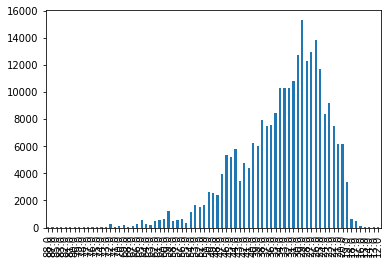

In [ ]:
G_1.age.value_counts().sort_index(ascending=False).plot(kind='bar')

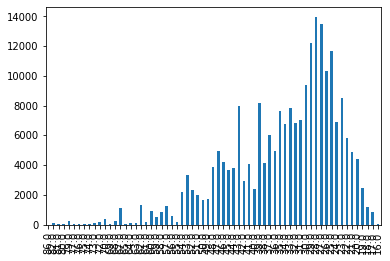

In [ ]:
G_2.age.value_counts().sort_index(ascending=False).plot(kind='bar')

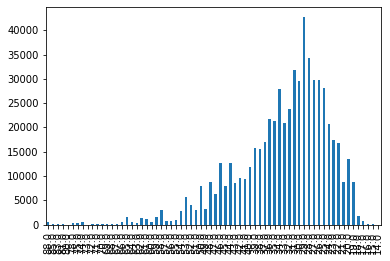

In [ ]:
G_3.age.value_counts().sort_index(ascending=False).plot(kind='bar')

# kmodes(Optional)

###!pip install kmodes
### We have lots of categorical varibles, so let's try k-modes (Gower’s similarity coefficient)
In K-modes algorithm, distance is measured by the number of common categorical attributes shared by the two data points

*There are lots of different cluster algorithm are available. Suggest you to read & try everything. Some popular are K Means, Agglomerative clustering, DBSCAN, Spectral clustering, Gaussian Mixtures, K-mode, Squeezer, CACTUS, ROCK, ..many more

In [ ]:
!pip install kmodes

*Conclusion:
Based on the data from clusters we can see that there are 4 clusters with totally different spread of users. 

As we can see in the cluster 1 & 3, people around age 30 & above have the highest presence. In cluster 2 and 4, there are almost nil Females population, based on that the most exclusive apps/plans should be directly promoted to people in that group. 

Gender to target in this group is of course: Male above 30 Years. They have equally distributed in all clusters.

To get clear differentiation, we need to get more data dimensions.

In [ ]:
from kmodes.kmodes import KModes
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(features_scaled)

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 114004, cost: 4557413.0
Run 1, iteration: 2/100, moves: 1722, cost: 4557413.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 57368, cost: 4558494.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 32859, cost: 4621117.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 111889, cost: 4552924.0
Run 4, iteration: 2/100, moves: 8593, cost: 4552924.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 51276, cost: 5104153.0
Best run was number 4
[[-1.43821957 -1.33098361 -0.56439555 -0.30153211  1.03028726 -0.63753072
   0.63753072]
 [-1.45680266 -1.39488853 -0.76961886 -0.30153211  0.98944467 -0.63753072
   0.63753072]
 [-1.45680266 -

In [ ]:
# add a column 'cluster' in the data giving cluster number corresponding to each observation
dff['cluster'] = km.labels_

# head() to display top five rows
dff.head()

,longitude,latitude,age,phone_brand_Cat,device_model_Cat,Type_is_F,Type_is_M,cluster
0,121.38,31.24,46.0,34,864,0,1,2
2,106.60,29.70,47.0,87,419,0,1,0
3,104.27,23.28,30.0,8,744,0,1,0
4,115.88,28.66,28.0,80,822,1,0,3
5,0.00,0.00,19.0,21,423,0,1,1


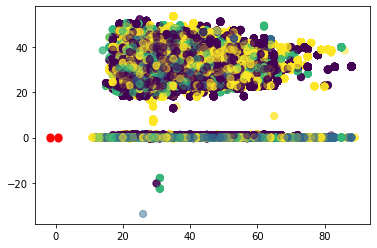

In [ ]:
plt.scatter(dff['age'], dff['latitude'], c= km.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:,6], centroids[:,3], c='red', s=50)
plt.show()

# KPrototypes algorithm (Optional)

* Lets try KPrototypes algo, Its a combination of K-Means and K-Modes for clustering mixed attributes
This will take time to execute

In [ ]:
from kmodes.kprototypes import KPrototypes

In [ ]:
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=2, random_state=22,n_jobs=5,max_iter=10,n_init=50)
clusters = kproto.fit_predict(dff,categorical=[2,3,6,7,8,9])

Best run was number 49


In [ ]:
np.unique(kproto.labels_, return_counts=True)
#Do profiling of each cluster as done above in other model iteration

(array([0, 1, 2, 3, 4], dtype=uint16),
 array([151301, 107736, 118717,  92632, 141474], dtype=int64))

In [ ]:
# try hierarchical clustering- agglomerative clustering:bottom-up approach
# Play with affinity & linkage parameter
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='manhattan', linkage='average')
cluster.fit_predict(reduced_data)

In [ ]:
#This method will work in case of many continious numeric variables. So we will not run it here.
# Please refer https://scikit-learn.org/stable/modules/clustering.html for details
#mean shift
from sklearn.cluster import MeanShift
mshift = MeanShift(bandwidth=25, n_init > 1)

In [ ]:
cluster_mean = mshift.fit(features_scaled)